# Generate the OCR synthdata

1. Take dataset map that just extracts the articles.
2. Split each one by word, with meta-data that keeps track of order of sentences so it can be pieced back together.
3. Create new dataset, and also function to map back to old dataset post inference.
4. Check it all works.

In [1]:
# load the dataset
from datasets import load_dataset

dataset = load_dataset(
    "multi_eurlex",
    "all_languages",
    label_level="level_3",
    trust_remote_code=True,
)

dataset

DatasetDict({
    train: Dataset({
        features: ['celex_id', 'text', 'labels'],
        num_rows: 55000
    })
    test: Dataset({
        features: ['celex_id', 'text', 'labels'],
        num_rows: 5000
    })
    validation: Dataset({
        features: ['celex_id', 'text', 'labels'],
        num_rows: 5000
    })
})

In [4]:
from arc_spice.data.multieurlex_utils import load_multieurlex

dataset = load_multieurlex(
    data_dir="../data", level=3, lang_pair={"source": "fr", "target": "en"}
)

In [44]:
t_dataset = dataset[0][0].select(range(10))
t_dataset

Dataset({
    features: ['celex_id', 'labels', 'source_text', 'target_text', 'class_labels'],
    num_rows: 10
})

In [58]:
# lets look at an example
eg1 = next(iter(t_dataset))

print(f"labels: \n {eg['labels']}")
print(f"celex id: \n {eg['celex_id']}")
print(f"text: \n {eg['source_text'].split(' ')}")
print(f"class labels: \n {eg['class_labels']}")

labels: 
 [57, 565, 129, 30, 45, 212]
celex id: 
 32006D0213
text: 
 ['\nArticle', 'premier\nLes', 'produits', 'et/ou', 'matériaux', 'de', 'construction', 'qui', 'satisfont', 'à', 'l’ensemble', 'des', 'prescriptions', 'relatives', 'à', 'la', 'caractéristique', '«réaction', 'au', 'feu»', 'sans', 'devoir', 'subir', 'd’essais', 'complémentaires', 'sont', 'énumérés', 'à', 'l’annexe.\nArticle', '2\nLes', 'classes', 'spécifiques', 'à', 'appliquer', 'aux', 'différents', 'produits', 'et/ou', 'matériaux', 'de', 'construction', 'au', 'sein', 'de', 'la', 'classification', 'des', 'caractéristiques', 'de', 'réaction', 'au', 'feu', 'adoptées', 'par', 'la', 'décision', '2000/147/CE', 'sont', 'indiquées', 'à', 'l’annexe', 'de', 'la', 'présente', 'décision.\nArticle', '3\nLes', 'produits', 'sont', 'considérés', 'au', 'regard', 'des', 'conditions', 'de', 'leur', 'utilisation', 'finale,', 'le', 'cas', 'échéant.\nArticle', '4\nLes', 'États', 'membres', 'sont', 'destinataires', 'de', 'la', 'présente', 'déc

Ok, so we want to generate OCR data here, with a source image and a target text, that is split by word in such a way that it can be easily pieced back together into the original text snippets.

The OCR generator method 'from Dict' just gives pre generated stuff, this isn't useful. Will have to maintain the dictionary structure myself.

In [94]:
from trdg.generators import GeneratorFromStrings
from datasets import Image


def make_ocr_data(example):
    """Take an input data row and transform it into OCR version word by word"""
    feature = Image(decode=False)
    text_split = example["source_text"].split(" ")
    print(len(text_split))
    generator = GeneratorFromStrings(text_split, count=len(text_split))
    return {
        "ocr_data": {
            str(idx): {"image": feature.encode_example(gen[0]), "target": gen[1]}
            for idx, gen in enumerate(generator)
        },
        "ocr_data": dict(
            [
                (idx, {"image": feature.encode_example(gen[0]), "target": gen[1]})
                for idx, gen in enumerate(generator)
            ]
        ),
        "word_count": len(text_split),
    }

In [95]:
new_data = t_dataset.map(make_ocr_data)

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

95
56
1912
186
296
62
154
78
56
232


In [96]:
new_data

Dataset({
    features: ['celex_id', 'labels', 'source_text', 'target_text', 'class_labels', 'ocr_data', 'word_count'],
    num_rows: 10
})

In [97]:
eg2 = next(iter(new_data))

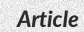

In [87]:
from PIL import Image
import io

display(Image.open(io.BytesIO(eg2["ocr_data"]["0"]["image"]["bytes"])))

In [88]:
len(eg2["ocr_data"].keys())

1912

In [99]:
eg2["ocr_data"]

{'0': {'image': {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00T\x00\x00\x00 \x08\x02\x00\x00\x00\x03\xba\xc8A\x00\x00\x14\x95IDATx\x9c=YY\xacUg\xd9^\xf3<\xec\xbd\xf6\xbc\xf7\x81\xc3a\xa8LJmSj$\xd5\x10\x83\xa2Q\x12\x891\xa6\x8dIc\xb4hz\xa9&&\x95\xa47\xc6\x98\xaaW\x96\x0bza\x0c\xbd\x80\x9b\xaa\x01\xabV\xdb(\t\x96z\xa1D\x10\xb4p\x86\xcd\x19\xf6\xbc\xe6y\xf4\xe2\xf9\xff\xc3%g\xaf\xb5\xbe\xef\xfd\xde\xf7\x99>2\xcfs\xd34g\xb3Y\xab\xd5*\xcb\x92e\xd98\x8e\xeb\xf5\xfax<V\x14\x85a\x988\x8e\x83 0\x0c#\xcf\xf3 \x08\x06\x83AUUa\x18J\x92\xe48N\xbb\xdd^[[3\x0c\x03\x0f\xca\xb2\xbc\xb9\xb9\xa9\xaaj\x96e\x8a\xa2\xcc\xe7\xf3C\x87\x0e\xb9\xaeKQTY\x96\xa6iVUU\xab\xd5\xd24\xf5<\xaf\xdb\xed\x8a\xa28\x1e\x8f9\x8e+\x8a\x82eY\x9e\xe7\xb3,+\x8a\x82\xa2\xa8\xa2(\\\xd7\x15\x04!\xcfs\x9e\xe7I\x92$\x08B\x92\xa4$I\x92$\xd9\xde\xde>y\xf2\xa4\xeb\xba\x8e\xe3\x08\x82@\x10\x84(\x8a4M\x8f\xc7\xe3\xa5\xa5\xa5\xc5b\x11\xc71\xc30a\x186\x1a\x8d0\x0c5M\xcb\xb2\xac,\xcb\xb2,\x83 PU\xb5(\njuu\xb5(\x8a}\xfb\xf6\xd5\x

In [61]:
eg1_text = eg1["source_text"]

['\nArticle', 'premier\nLes', 'produits', 'et/ou', 'matériaux', 'de', 'construction', 'qui', 'satisfont', 'à', 'l’ensemble', 'des', 'prescriptions', 'relatives', 'à', 'la', 'caractéristique', '«réaction', 'au', 'feu»', 'sans', 'devoir', 'subir', 'd’essais', 'complémentaires', 'sont', 'énumérés', 'à', 'l’annexe.\nArticle', '2\nLes', 'classes', 'spécifiques', 'à', 'appliquer', 'aux', 'différents', 'produits', 'et/ou', 'matériaux', 'de', 'construction', 'au', 'sein', 'de', 'la', 'classification', 'des', 'caractéristiques', 'de', 'réaction', 'au', 'feu', 'adoptées', 'par', 'la', 'décision', '2000/147/CE', 'sont', 'indiquées', 'à', 'l’annexe', 'de', 'la', 'présente', 'décision.\nArticle', '3\nLes', 'produits', 'sont', 'considérés', 'au', 'regard', 'des', 'conditions', 'de', 'leur', 'utilisation', 'finale,', 'le', 'cas', 'échéant.\nArticle', '4\nLes', 'États', 'membres', 'sont', 'destinataires', 'de', 'la', 'présente', 'décision.\nFait', 'à', 'Bruxelles,', 'le', '6', 'mars', '2006.']
0
(<PIL

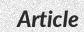


Article
1
(<PIL.Image.Image image mode=RGB size=147x32 at 0x2EDF3B6D0>, 'premier\nLes')


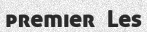

premier
Les
2
(<PIL.Image.Image image mode=RGB size=73x32 at 0x2E0402170>, 'produits')


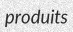

produits
3
(<PIL.Image.Image image mode=RGB size=57x32 at 0x2E0402AD0>, 'et/ou')


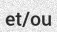

et/ou
4
(<PIL.Image.Image image mode=RGB size=65x32 at 0x2E04023B0>, 'matériaux')


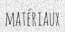

matériaux
5
(<PIL.Image.Image image mode=RGB size=37x32 at 0x2E04025F0>, 'de')


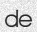

de
6
(<PIL.Image.Image image mode=RGB size=139x32 at 0x2E0403FA0>, 'construction')


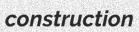

construction
7
(<PIL.Image.Image image mode=RGB size=33x32 at 0x2E0401C30>, 'qui')


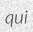

qui
8
(<PIL.Image.Image image mode=RGB size=90x32 at 0x2E380C8E0>, 'satisfont')


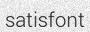

satisfont
9
(<PIL.Image.Image image mode=RGB size=23x32 at 0x2E0402FB0>, 'à')


à
10
(<PIL.Image.Image image mode=RGB size=130x32 at 0x2E04025F0>, 'l’ensemble')


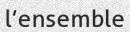

l’ensemble
11
(<PIL.Image.Image image mode=RGB size=43x32 at 0x2E1EC0070>, 'des')


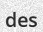

des
12
(<PIL.Image.Image image mode=RGB size=118x32 at 0x2E0401F90>, 'prescriptions')


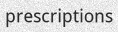

prescriptions
13
(<PIL.Image.Image image mode=RGB size=87x32 at 0x2E0402980>, 'relatives')


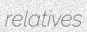

relatives
14
(<PIL.Image.Image image mode=RGB size=21x32 at 0x2EDF3B6D0>, 'à')


à
15
(<PIL.Image.Image image mode=RGB size=25x32 at 0x2E35EFB20>, 'la')


la
16
(<PIL.Image.Image image mode=RGB size=151x32 at 0x2EDF3B6D0>, 'caractéristique')


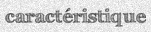

caractéristique
17
(<PIL.Image.Image image mode=RGB size=100x32 at 0x2E0403F70>, '«réaction')


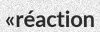

«réaction
18
(<PIL.Image.Image image mode=RGB size=34x32 at 0x2E380C8E0>, 'au')


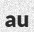

au
19
(<PIL.Image.Image image mode=RGB size=51x32 at 0x2E0403CA0>, 'feu»')


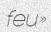

feu»
20
(<PIL.Image.Image image mode=RGB size=48x32 at 0x2E380C8E0>, 'sans')


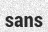

sans
21
(<PIL.Image.Image image mode=RGB size=81x32 at 0x2E0403F70>, 'devoir')


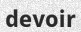

devoir
22
(<PIL.Image.Image image mode=RGB size=60x32 at 0x2E0402FE0>, 'subir')


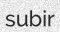

subir
23
(<PIL.Image.Image image mode=RGB size=73x32 at 0x2E1A5EE90>, 'd’essais')


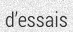

d’essais
24
(<PIL.Image.Image image mode=RGB size=155x32 at 0x2E35EFB20>, 'complémentaires')


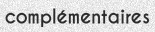

complémentaires
25
(<PIL.Image.Image image mode=RGB size=55x32 at 0x2E380C8E0>, 'sont')


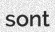

sont
26
(<PIL.Image.Image image mode=RGB size=98x32 at 0x2E0403FA0>, 'énumérés')


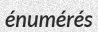

énumérés
27
(<PIL.Image.Image image mode=RGB size=16x32 at 0x2E380C8E0>, 'à')


à
28
(<PIL.Image.Image image mode=RGB size=158x32 at 0x2E04023B0>, 'l’annexe.\nArticle')


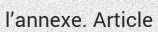

l’annexe.
Article
29
(<PIL.Image.Image image mode=RGB size=62x32 at 0x2E380C8E0>, '2\nLes')


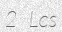

2
Les
30
(<PIL.Image.Image image mode=RGB size=89x32 at 0x2E0402020>, 'classes')


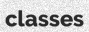

classes
31
(<PIL.Image.Image image mode=RGB size=94x32 at 0x2E0402FB0>, 'spécifiques')


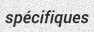

spécifiques
32
(<PIL.Image.Image image mode=RGB size=23x32 at 0x2E0403F40>, 'à')


à
33
(<PIL.Image.Image image mode=RGB size=146x32 at 0x2E380C8E0>, 'appliquer')


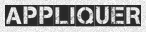

appliquer
34
(<PIL.Image.Image image mode=RGB size=37x32 at 0x2E0403A30>, 'aux')


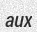

aux
35
(<PIL.Image.Image image mode=RGB size=109x32 at 0x2E0402020>, 'différents')


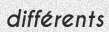

différents
36
(<PIL.Image.Image image mode=RGB size=79x32 at 0x2E1EC0070>, 'produits')


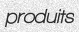

produits
37
(<PIL.Image.Image image mode=RGB size=67x32 at 0x2E0401C30>, 'et/ou')


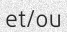

et/ou
38
(<PIL.Image.Image image mode=RGB size=106x32 at 0x2E0403F70>, 'matériaux')


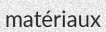

matériaux
39
(<PIL.Image.Image image mode=RGB size=28x32 at 0x2E0401570>, 'de')


de
40
(<PIL.Image.Image image mode=RGB size=123x32 at 0x2E0402170>, 'construction')


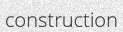

construction
41
(<PIL.Image.Image image mode=RGB size=34x32 at 0x2E1EC0070>, 'au')


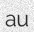

au
42
(<PIL.Image.Image image mode=RGB size=47x32 at 0x2E0401840>, 'sein')


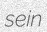

sein
43
(<PIL.Image.Image image mode=RGB size=33x32 at 0x2E04023B0>, 'de')


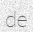

de
44
(<PIL.Image.Image image mode=RGB size=30x32 at 0x2E04033D0>, 'la')


la
45
(<PIL.Image.Image image mode=RGB size=102x32 at 0x2E0401B10>, 'classification')


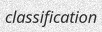

classification
46
(<PIL.Image.Image image mode=RGB size=45x32 at 0x2E380C8E0>, 'des')


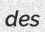

des
47
(<PIL.Image.Image image mode=RGB size=140x32 at 0x2E0402980>, 'caractéristiques')


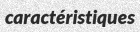

caractéristiques
48
(<PIL.Image.Image image mode=RGB size=38x32 at 0x2E04038E0>, 'de')


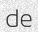

de
49
(<PIL.Image.Image image mode=RGB size=113x32 at 0x2E380C8E0>, 'réaction')


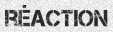

réaction
50
(<PIL.Image.Image image mode=RGB size=33x32 at 0x2E1EC0070>, 'au')


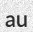

au
51
(<PIL.Image.Image image mode=RGB size=43x32 at 0x2E04038E0>, 'feu')


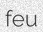

feu
52
(<PIL.Image.Image image mode=RGB size=93x32 at 0x2E1A5EE90>, 'adoptées')


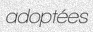

adoptées
53
(<PIL.Image.Image image mode=RGB size=38x32 at 0x2E380C8E0>, 'par')


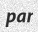

par
54
(<PIL.Image.Image image mode=RGB size=28x32 at 0x2EDF38400>, 'la')


la
55
(<PIL.Image.Image image mode=RGB size=95x32 at 0x2E0401C30>, 'décision')


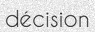

décision
56
(<PIL.Image.Image image mode=RGB size=148x32 at 0x2E0402FB0>, '2000/147/CE')


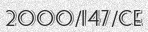

2000/147/CE
57
(<PIL.Image.Image image mode=RGB size=49x32 at 0x2E04025F0>, 'sont')


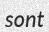

sont
58
(<PIL.Image.Image image mode=RGB size=70x32 at 0x2E0401B70>, 'indiquées')


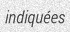

indiquées
59
(<PIL.Image.Image image mode=RGB size=22x32 at 0x2E0403BB0>, 'à')


à
60
(<PIL.Image.Image image mode=RGB size=59x32 at 0x2E0401B70>, 'l’annexe')


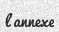

l’annexe
61
(<PIL.Image.Image image mode=RGB size=30x32 at 0x2E35EFB20>, 'de')


de
62
(<PIL.Image.Image image mode=RGB size=30x32 at 0x2E0401F90>, 'la')


la
63
(<PIL.Image.Image image mode=RGB size=87x32 at 0x2E1A5EE90>, 'présente')


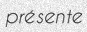

présente
64
(<PIL.Image.Image image mode=RGB size=150x32 at 0x2E0401570>, 'décision.\nArticle')


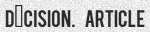

décision.
Article
65
(<PIL.Image.Image image mode=RGB size=76x32 at 0x2E1A5EE90>, '3\nLes')


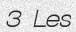

3
Les
66
(<PIL.Image.Image image mode=RGB size=73x32 at 0x2E04033D0>, 'produits')


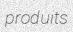

produits
67
(<PIL.Image.Image image mode=RGB size=56x32 at 0x2E1A5EE90>, 'sont')


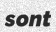

sont
68
(<PIL.Image.Image image mode=RGB size=98x32 at 0x2E04022F0>, 'considérés')


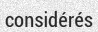

considérés
69
(<PIL.Image.Image image mode=RGB size=33x32 at 0x2E0402B00>, 'au')


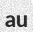

au
70
(<PIL.Image.Image image mode=RGB size=66x32 at 0x2E0402B90>, 'regard')


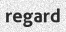

regard
71
(<PIL.Image.Image image mode=RGB size=44x32 at 0x2E0402980>, 'des')


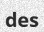

des
72
(<PIL.Image.Image image mode=RGB size=103x32 at 0x2E380C8E0>, 'conditions')


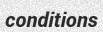

conditions
73
(<PIL.Image.Image image mode=RGB size=32x32 at 0x2E1EC0070>, 'de')


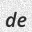

de
74
(<PIL.Image.Image image mode=RGB size=42x32 at 0x2EDF38400>, 'leur')


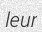

leur
75
(<PIL.Image.Image image mode=RGB size=111x32 at 0x2E0403340>, 'utilisation')


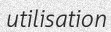

utilisation
76
(<PIL.Image.Image image mode=RGB size=60x32 at 0x2E04022F0>, 'finale,')


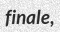

finale,
77
(<PIL.Image.Image image mode=RGB size=26x32 at 0x2E0402020>, 'le')


le
78
(<PIL.Image.Image image mode=RGB size=45x32 at 0x2EDF3B6D0>, 'cas')


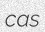

cas
79
(<PIL.Image.Image image mode=RGB size=178x32 at 0x2E0402B90>, 'échéant.\nArticle')


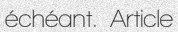

échéant.
Article
80
(<PIL.Image.Image image mode=RGB size=66x32 at 0x2EDF38400>, '4\nLes')


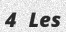

4
Les
81
(<PIL.Image.Image image mode=RGB size=59x32 at 0x2E0401840>, 'États')


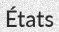

États
82
(<PIL.Image.Image image mode=RGB size=104x32 at 0x2EDF38400>, 'membres')


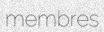

membres
83
(<PIL.Image.Image image mode=RGB size=47x32 at 0x2EDF3B6D0>, 'sont')


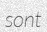

sont
84
(<PIL.Image.Image image mode=RGB size=127x32 at 0x2E0403F40>, 'destinataires')


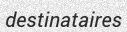

destinataires
85
(<PIL.Image.Image image mode=RGB size=31x32 at 0x2E1A5EE90>, 'de')


de
86
(<PIL.Image.Image image mode=RGB size=26x32 at 0x2E0402B00>, 'la')


la
87
(<PIL.Image.Image image mode=RGB size=89x32 at 0x2E0402980>, 'présente')


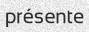

présente
88
(<PIL.Image.Image image mode=RGB size=143x32 at 0x2E0401570>, 'décision.\nFait')


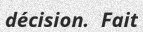

décision.
Fait
89
(<PIL.Image.Image image mode=RGB size=21x32 at 0x2E04038E0>, 'à')


à
90
(<PIL.Image.Image image mode=RGB size=85x32 at 0x2E380C8E0>, 'Bruxelles,')


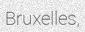

Bruxelles,
91
(<PIL.Image.Image image mode=RGB size=26x32 at 0x2E1EC0070>, 'le')


le
92
(<PIL.Image.Image image mode=RGB size=23x32 at 0x2E0401F90>, '6')


6
93
(<PIL.Image.Image image mode=RGB size=55x32 at 0x2E04033D0>, 'mars')


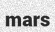

mars
94
(<PIL.Image.Image image mode=RGB size=79x32 at 0x2E380C8E0>, '2006.')


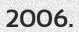

2006.


In [78]:
split_text = eg1_text.split(" ")
print(split_text)
gen = GeneratorFromStrings(split_text, count=len(split_text))
for idx, g in enumerate(gen):
    print(str(idx))
    print(g)
    display(g[0])
    print(g[1])